In [1]:
import sys

sys.path.append("..")
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from sklearn.model_selection import KFold
import numpy as np
from dory.regression.mlp import MultilayerPerceptronRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
df = pd.read_csv("concrete.csv", header=None)
df.describe()

,0,1,2,3,4,5,6,7,8
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [3]:
random_state = 42069
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(824, 8) (206, 8) (824,) (206,)


In [4]:
param_dist = {
    "hidden_layer_sizes": [[i] for i in range(1, 100 + 1)],
    "learning_rate": np.logspace(np.log10(0.0001), np.log10(0.1), num=10),
    "momentum": np.linspace(0.9, 0.99, num=10),
}

model = MultilayerPerceptronRegressor(
    random_state=random_state, batch_size=32, should_validate=False
)
splits = 5
n_iter = 100

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=n_iter,
    cv=splits,
    random_state=random_state,
    n_jobs=-1,
    verbose=1,
)

random_search

,estimator,MultilayerPer...alidate=False)
,param_distributions,"{'hidden_layer_sizes': [[1], [2], ...], 'learning_rate': array([0.0001..., 0.1 ]), 'momentum': array([0.9 , ..., 0.98, 0.99])}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42069
,error_score,nan


In [5]:
random_search.fit(X_train, y_train)
print("Best parameters found: ", random_search.best_params_)
best_model = random_search.best_estimator_
best_model

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/flemis/codes/dory/.venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1146: RuntimeWarning: overflow encountered in square
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Best parameters found:  {'momentum': np.float64(0.93), 'learning_rate': np.float64(0.001), 'hidden_layer_sizes': [97]}


,hidden_layer_sizes,[97]
,batch_size,32
,max_iter,200
,random_state,42069
,learning_rate,np.float64(0.001)
,momentum,np.float64(0.93)
,validation_size,0.2
,shuffle,True
,should_validate,False


In [6]:
model = MultilayerPerceptronRegressor(**random_search.best_params_, should_validate=True)

model.fit(X_train, y_train)
Y_pred = model.predict(X_test)

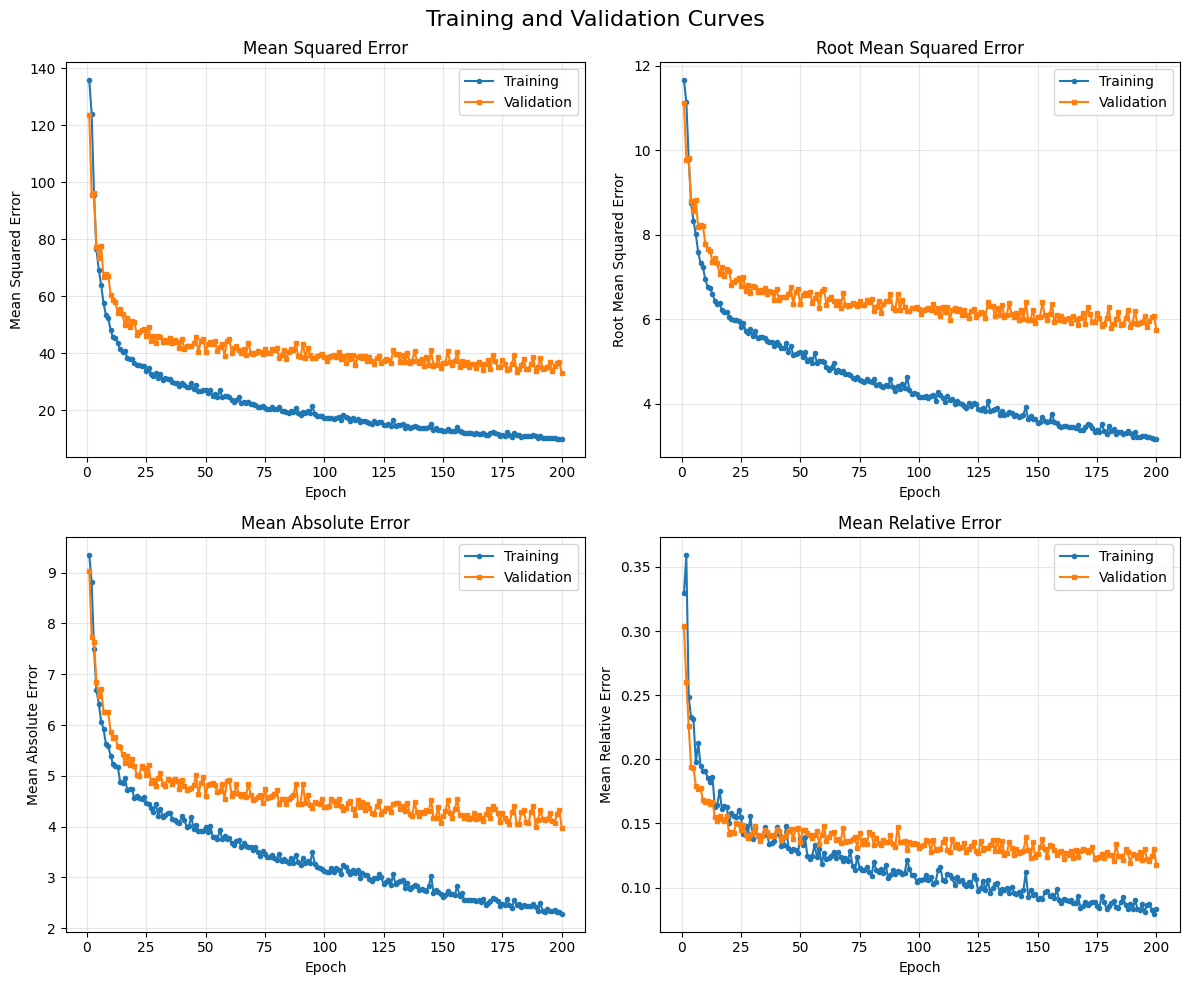

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Training and Validation Curves", fontsize=16)

metrics = ["mse", "rmse", "mae", "mre"]
titles = [
    "Mean Squared Error",
    "Root Mean Squared Error",
    "Mean Absolute Error",
    "Mean Relative Error",
]

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    epochs = range(1, len(model.train_errors_) + 1)

    ax.plot(
        epochs, model.train_errors_[metric], label="Training", marker="o", markersize=3
    )
    ax.plot(
        epochs, model.val_errors_[metric], label="Validation", marker="s", markersize=3
    )

    ax.set_xlabel("Epoch")
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, Y_pred)
print(f"Final MSE: {mse}")

Final MSE: 18.386263812978015
